# <b>Projekt 2. - Wykrywanie naczyń dna siatkówki oka</b>
### <b>Autorzy:</b> Wiktoria Białasik 151436, Mateusz Czechowski 155921

## <u>Zastosowany język programowania oraz użyte biblioteki</u>
<p> W projekcie wykorzystano język programowania <b>Python</b> oraz posłużono się bibliotekami wymienionymi poniżej. 

In [28]:
import os
import ipywidgets as widgets
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import frangi
from IPython.display import display, clear_output
from skimage.exposure import rescale_intensity
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import gmean
from sklearn.metrics import classification_report
import seaborn as sns

### Odczyt oraz wyświetlenie obrazu wejściwego - zdjęcia siatkówki oka

Dropdown(description='Pick image', index=21, options=('10_bad.JPG', '10_good.JPG', '11_bad.JPG', '11_good.JPG'…

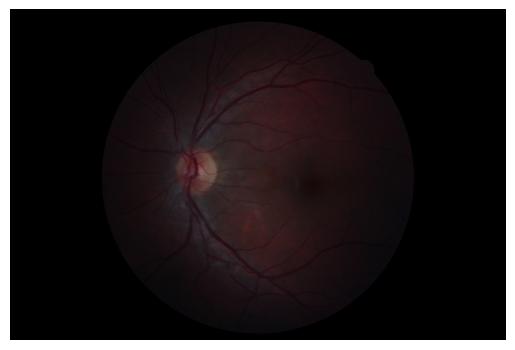

In [11]:
image = None
filename = ''
dir = './input-data/'
examples_list = [file for file in os.listdir(dir) ]

filename_picker = widgets.Dropdown(
    options=examples_list,
    description="Pick image",
    disabled=False
)

def show(change):
    global image, filename, image_color
    clear_output(wait=True)
    display(filename_picker)
    selected_file = change['new']
    
    if selected_file:
        file_path = os.path.join(dir, selected_file)
    
        image = mpimg.imread(file_path)
        if len(image.shape) == 3:
            plt.imshow(image) 
            plt.axis('off')
            plt.show()
            image_color = (image * 255).astype(np.uint8)
            image = np.mean(image, axis=2)

        filename = os.path.splitext(filename_picker.value)[0]
        print(filename)

filename_picker.observe(show, names='value')
display(filename_picker)


### Wstępne przetwarzanie obrazu

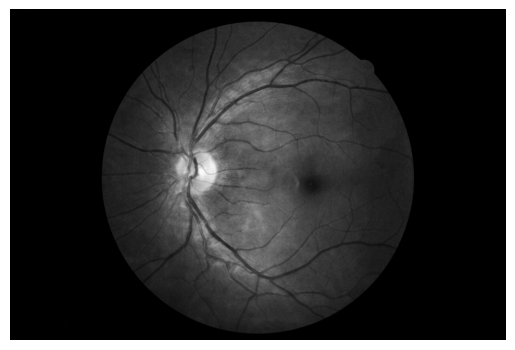

In [12]:
def preprocess_image(image):
    if len(image.shape) == 3:
        green_channel = image[:, :, 1] 
    else:
        green_channel = image

    green_channel = green_channel.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_eq = clahe.apply(green_channel)
    median = cv2.medianBlur(image_eq, 5)
    blurred = cv2.GaussianBlur(median, (5, 5), 0)

    return blurred

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

blured_image = preprocess_image(image)
show_image(blured_image) 


### Właściwe przetwarzanie obrazu - Filtr Frangiego

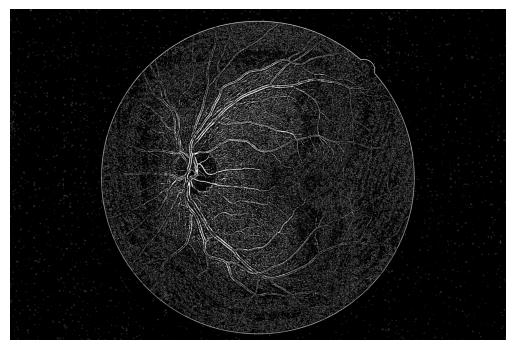

In [17]:
def frangi_filter(image, threshold=0.015, to_255=True):
    image = image.astype(np.float64) / 255.0
    frangi_result = frangi(image)
    binary_mask = (frangi_result > threshold).astype(np.uint8)

    return binary_mask

vessel_mask = frangi_filter(blured_image)
show_image(vessel_mask)



### Końcowe przetwarzanie - oczyszczanie maski

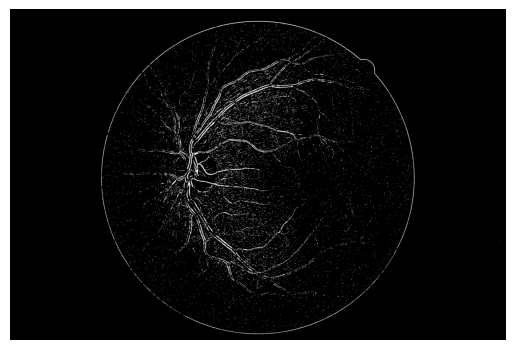

In [19]:
def postprocess_mask(mask):
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    return cleaned

postprocessed_mask = postprocess_mask(vessel_mask)
show_image(postprocessed_mask)

### Nakłądanie konturów na oryginalny obraz

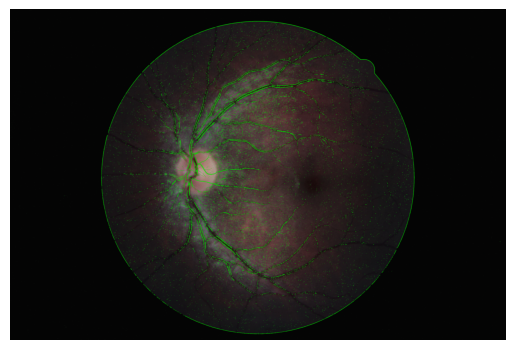

True

In [59]:
def visualize_mask(original, mask, color=(0, 255, 0), alpha=0.7, enhance_contrast=True):
    if enhance_contrast:
        lab = cv2.cvtColor(original, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        original = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    overlay = original.copy()
    overlay[mask == 1] = color
    return cv2.addWeighted(original, 1 - alpha, overlay, alpha, 0)

file_path = os.path.join(dir, filename + '.jpg')

img = cv2.imread(file_path)
vis = visualize_mask(img, postprocessed_mask, color=(0, 255, 0), alpha=0.7)

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

output_folder = 'output-data'
os.makedirs(output_folder, exist_ok=True)

output_path = os.path.join(output_folder, 'vessels_overlay.png')
cv2.imwrite(output_path, vis)

Metryki...........

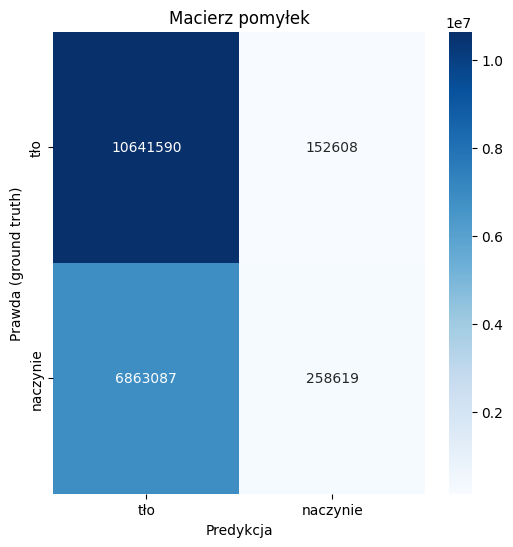

              precision    recall  f1-score   support

         tło       0.61      0.99      0.75  10794198
    naczynie       0.63      0.04      0.07   7121706

    accuracy                           0.61  17915904
   macro avg       0.62      0.51      0.41  17915904
weighted avg       0.62      0.61      0.48  17915904



In [38]:
if image.dtype == np.float32 or image.dtype == np.float64:
    img_uint8 = (image * 255).astype(np.uint8)
else:
    img_uint8 = image

if len(img_uint8.shape) == 3:
    gray_mask = np.mean(img_uint8, axis=2).astype(np.uint8)
else:
    gray_mask = img_uint8.astype(np.uint8)

expert_mask_bin = (gray_mask > 127).astype(np.uint8)

y_true = expert_mask_bin.flatten()
y_pred = postprocessed_mask.flatten()

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['tło', 'naczynie'], yticklabels=['tło', 'naczynie'])
plt.xlabel('Predykcja')
plt.ylabel('Prawda (ground truth)')
plt.title('Macierz pomyłek')
plt.show()

print(classification_report(y_true, y_pred, target_names=['tło', 'naczynie']))